In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys

# Para rodar no notebook
%matplotlib inline

# Adiciona o diretório src ao sys.path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Ignorar avisos desnecessários
import warnings
warnings.filterwarnings('ignore')

# Importar as funções de data augmentation
from funcoes_augmentation import load_and_preprocess_image, fixed_rotation, adjust_brightness, adjust_contrast,adjust_saturation
from data_utils import create_datasets_efficientnet
from models import create_model_b0, create_model_b1
from training_utils import train_and_evaluate_model

Using TensorFlow backend


# Treinamento do Modelo de Classificação de Artefatos Arqueológicos

Neste notebook, realizaremos o treinamento de um modelo de classificação de imagens de artefatos arqueológicos utilizando uma rede neural convolucional baseada na EfficientNet. O objetivo é avaliar o impacto de diferentes técnicas de data augmentation no desempenho do modelo, testando cada técnica individualmente e buscando os níveis ótimos antes de combiná-las.

---

In [2]:
# Diretórios de dados
train_dir = '../dados/brutos/train'
test_dir = '../dados/brutos/test'

# Lista das classes
classes = ['classe1_Vidro', 'classe2_Ceramica', 'classe3_Litico', 'classe4_Louca']

# Mapeamento das classes para índices
class_indices = {cls_name: idx for idx, cls_name in enumerate(classes)}
class_names = list(class_indices.keys())

# Parâmetros do modelo
batch_size = 32
img_height = 256
img_width = 256
num_classes = len(classes)
epochs = 40

In [3]:
# Criar os datasets
train_ds, test_ds = create_datasets_efficientnet(
    train_dir=train_dir,
    test_dir=test_dir,
    classes=classes,
    batch_size=batch_size,
    img_height=img_height,
    img_width=img_width
)

Número mínimo de imagens por classe para balanceamento: 311
Conjunto de treinamento balanceado possui 1244 imagens.
Distribuição de imagens por classe no conjunto de treinamento balanceado:
  Classe 'classe1_Vidro': 311 imagens
  Classe 'classe2_Ceramica': 311 imagens
  Classe 'classe3_Litico': 311 imagens
  Classe 'classe4_Louca': 311 imagens
Conjunto de teste possui 384 imagens.


# Definição do Modelo

Carregar o Modelo Base EfficientNet

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

def create_model(num_classes):
    # Carregar o modelo base
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Transfer learning - congelar as camadas convolucionais

    # Construir a arquitetura do modelo
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

In [ ]:
# Função para plotar o gráfico de loss e accuracy
def plot_history(history):
    # Plotar o Loss
    plt.figure(figsize=(12, 5))

    # Gráfico de Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Loss de Treinamento')
    plt.plot(history.history['val_loss'], label='Loss de Validação')
    plt.title('Loss durante o Treinamento e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()

    # Gráfico de Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia durante o Treinamento e Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.legend()

    # Exibir os gráficos
    plt.show()

# Compilação do Modelo

Definimos o otimizador, a função de perda e as métricas.

In [6]:
# Criar o modelo
model = create_model(num_classes)

# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

16705208/16705208 [==============================] - 2s 0us/step


# Treinamento do Modelo

Vamos treinar o modelo em diferentes cenários:

- Baseline: Sem data augmentation.
- Com cada técnica de data augmentation individualmente.

Criar o Dataset de Treinamento Sem Data Augmentation:

In [4]:
# Dataset de treinamento sem data augmentation
train_ds_baseline = train_ds

Treinar o Modelo

In [5]:
# Treinamento Baseline (sem aumento de dados)
train_and_evaluate_model(
    create_model_func = create_model_b0,
    train_dataset=train_ds_baseline,
    validation_dataset=test_ds,
    num_classes=num_classes,
    epochs=epochs,
    history_path='training_histories/history_baseline.json',
    model_checkpoint_path='best_model_baseline.keras',
    patience=40,
    restore_best_weights=True
)

Epoch 1/40
39/39 [==============================] - ETA: 0s - loss: 1.7704 - accuracy: 0.3424

ValueError: The following argument(s) are not supported with the native Keras format: ['options']

In [ ]:
# Dicionário para armazenar os históricos carregados
histories = {}

# Carregar histórico Baseline
histories['baseline'] = load_history('training_histories/history_baseline.json')

# Envolver o histórico 'baseline' em um dicionário
baseline_history = {'baseline': histories['baseline']}

In [ ]:
# Plotar apenas o histórico 'baseline'
plot_histories(baseline_history, metric='accuracy')
plot_histories(baseline_history, metric='loss')

# Treinamento com Data Augmentation Individualmente

In [9]:
def create_augmented_dataset(augmentation_function):
    ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
    ds = ds.map(
        lambda x, y: (load_and_preprocess_image(x), y)
    ).map(
        lambda x, y: (augmentation_function(x), y)
    ).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

## Treinamento com Rotação Aleatória de ±10°

In [ ]:
# Função de data augmentation específica
def augmentation_rotation_10(image):
    return random_rotation(image, max_angle=10)

# Criar o dataset
train_ds_rotation_10 = create_augmented_dataset(augmentation_rotation_10)

# Recriar e compilar o modelo
model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar o modelo
history_rotation_10 = model.fit(
    train_ds_rotation_10,
    validation_data=test_ds,
    epochs=epochs
)

# Salvar o histórico
histories['rotation_10'] = history_rotation_10

## Treinamento com Rotação Aleatória de ±15°

In [ ]:
# Função de data augmentation específica
def augmentation_rotation_15(image):
    return random_rotation(image, max_angle=15)

# Criar o dataset
train_ds_rotation_15 = create_augmented_dataset(augmentation_rotation_15)

# Recriar e compilar o modelo
model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar o modelo
history_rotation_15 = model.fit(
    train_ds_rotation_15,
    validation_data=test_ds,
    epochs=epochs
)

# Salvar o histórico
histories['rotation_15'] = history_rotation_15

## Treinamento com Rotação Aleatória de ±20°

In [ ]:
def augmentation_rotation_20(image):
    return random_rotation(image, max_angle=20)

train_ds_rotation_20 = create_augmented_dataset(augmentation_rotation_20)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_rotation_20 = model.fit(
    train_ds_rotation_20,
    validation_data=test_ds,
    epochs=epochs
)

histories['rotation_20'] = history_rotation_20

## Treinamento com Rotação Fixa de +10°

In [ ]:
def augmentation_fixed_rotation_plus_10(image):
    return fixed_rotation(image, angle=10)

train_ds_fixed_rotation_plus_10 = create_augmented_dataset(augmentation_fixed_rotation_plus_10)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fixed_rotation_plus_10 = model.fit(
    train_ds_fixed_rotation_plus_10,
    validation_data=test_ds,
    epochs=epochs
)

histories['fixed_rotation_plus_10'] = history_fixed_rotation_plus_10

## Treinamento com Rotação Fixa de -10°

In [ ]:
def augmentation_fixed_rotation_minus_10(image):
    return fixed_rotation(image, angle=-10)

train_ds_fixed_rotation_minus_10 = create_augmented_dataset(augmentation_fixed_rotation_minus_10)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fixed_rotation_minus_10 = model.fit(
    train_ds_fixed_rotation_minus_10,
    validation_data=test_ds,
    epochs=epochs
)

histories['fixed_rotation_minus_10'] = history_fixed_rotation_minus_10

## Treinamento com Brilho +10%

In [ ]:
def augmentation_brightness_10(image):
    return adjust_brightness(image, delta=0.1)

train_ds_brightness_10 = create_augmented_dataset(augmentation_brightness_10)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_brightness_10 = model.fit(
    train_ds_brightness_10,
    validation_data=test_ds,
    epochs=epochs
)

histories['brightness_10'] = history_brightness_10

## Treinamento com Brilho +20%

In [ ]:
def augmentation_brightness_20(image):
    return adjust_brightness(image, delta=0.2)

train_ds_brightness_20 = create_augmented_dataset(augmentation_brightness_20)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_brightness_20 = model.fit(
    train_ds_brightness_20,
    validation_data=test_ds,
    epochs=epochs
)

histories['brightness_20'] = history_brightness_20

## Treinamento com Brilho +30%

In [ ]:
def augmentation_brightness_30(image):
    return adjust_brightness(image, delta=0.3)

train_ds_brightness_30 = create_augmented_dataset(augmentation_brightness_30)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_brightness_30 = model.fit(
    train_ds_brightness_30,
    validation_data=test_ds,
    epochs=epochs
)

histories['brightness_30'] = history_brightness_30

## Treinamento com Espelhamento Horizontal 

In [ ]:
def augmentation_flip_horizontal(image):
    return flip_horizontal(image)

train_ds_flip_horizontal = create_augmented_dataset(augmentation_flip_horizontal)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_flip_horizontal = model.fit(
    train_ds_flip_horizontal,
    validation_data=test_ds,
    epochs=epochs
)

histories['flip_horizontal'] = history_flip_horizontal

## Treinamento com Espelhamento Vertical

In [ ]:
def augmentation_flip_vertical(image):
    return flip_vertical(image)

train_ds_flip_vertical = create_augmented_dataset(augmentation_flip_vertical)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_flip_vertical = model.fit(
    train_ds_flip_vertical,
    validation_data=test_ds,
    epochs=epochs
)

histories['flip_vertical'] = history_flip_vertical

## Treinamento com Zoom entre 1.0 e 1.2 até 20%

In [ ]:
def augmentation_zoom_1_2(image):
    return random_zoom(image, zoom_range=(1.0, 1.2))

train_ds_zoom_1_2 = create_augmented_dataset(augmentation_zoom_1_2)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_zoom_1_2 = model.fit(
    train_ds_zoom_1_2,
    validation_data=test_ds,
    epochs=epochs
)

histories['zoom_1_2'] = history_zoom_1_2

## Treinamento com Zoom entre 1.0 e 1.5 até 50%

In [ ]:
def augmentation_zoom_1_5(image):
    return random_zoom(image, zoom_range=(1.0, 1.5))

train_ds_zoom_1_5 = create_augmented_dataset(augmentation_zoom_1_5)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_zoom_1_5 = model.fit(
    train_ds_zoom_1_5,
    validation_data=test_ds,
    epochs=epochs
)

histories['zoom_1_5'] = history_zoom_1_5


## Treinamento com Cisalhamento de 10°

In [ ]:
def augmentation_shear_10(image):
    return random_shear(image, shear_level=10)

train_ds_shear_10 = create_augmented_dataset(augmentation_shear_10)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_shear_10 = model.fit(
    train_ds_shear_10,
    validation_data=test_ds,
    epochs=epochs
)

histories['shear_10'] = history_shear_10

## Treinamento com Cisalhamento de 20°

In [ ]:
def augmentation_shear_20(image):
    return random_shear(image, shear_level=20)

train_ds_shear_20 = create_augmented_dataset(augmentation_shear_20)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_shear_20 = model.fit(
    train_ds_shear_20,
    validation_data=test_ds,
    epochs=epochs
)

histories['shear_20'] = history_shear_20

## Treinamento com Ajuste Aleatório de Contraste 

In [ ]:
def augmentation_contrast(image):
    return random_contrast(image, lower=0.8, upper=1.2)

train_ds_contrast = create_augmented_dataset(augmentation_contrast)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_contrast = model.fit(
    train_ds_contrast,
    validation_data=test_ds,
    epochs=epochs
)

histories['contrast'] = history_contrast

## Treinamento com Ajuste Aleatório de Saturação

In [ ]:
def augmentation_saturation(image):
    return random_saturation(image, lower=0.8, upper=1.2)

train_ds_saturation = create_augmented_dataset(augmentation_saturation)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_saturation = model.fit(
    train_ds_saturation,
    validation_data=test_ds,
    epochs=epochs
)

histories['saturation'] = history_saturation

## Treinamento com Ajuste Aleatório de Matiz 

In [ ]:
def augmentation_hue(image):
    return random_hue(image, max_delta=0.02)

train_ds_hue = create_augmented_dataset(augmentation_hue)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_hue = model.fit(
    train_ds_hue,
    validation_data=test_ds,
    epochs=epochs
)

histories['hue'] = history_hue

## Treinamento com Adição de Ruído Gaussiano

In [ ]:
def augmentation_gaussian_noise(image):
    return add_gaussian_noise(image, mean=0.0, stddev=0.05)

train_ds_gaussian_noise = create_augmented_dataset(augmentation_gaussian_noise)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_gaussian_noise = model.fit(
    train_ds_gaussian_noise,
    validation_data=test_ds,
    epochs=epochs
)

histories['gaussian_noise'] = history_gaussian_noise

## Treinamento com Conversão para Escala de Cinza 10% de probabilidade

In [ ]:
def augmentation_grayscale(image):
    return random_grayscale(image, probability=0.1)

train_ds_grayscale = create_augmented_dataset(augmentation_grayscale)

model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_grayscale = model.fit(
    train_ds_grayscale,
    validation_data=test_ds,
    epochs=epochs
)

histories['grayscale'] = history_grayscale

# Avaliação dos Resultados

In [11]:
def plot_metric(histories, metric, title):
    plt.figure(figsize=(12, 6))
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} - treino')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} - val')
    plt.title(title)
    plt.xlabel('Épocas')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()


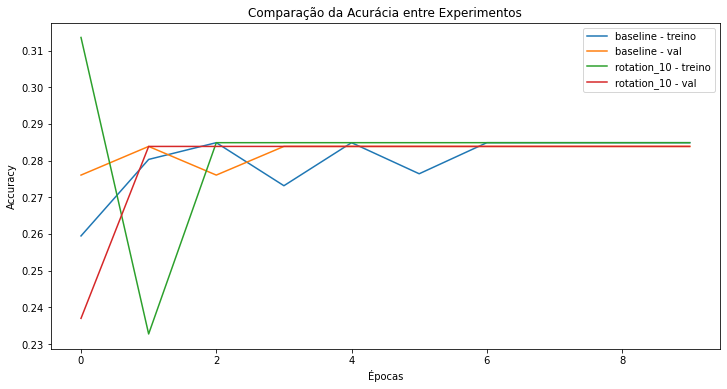

In [12]:
plot_metric(histories, 'accuracy', 'Comparação da Acurácia entre Experimentos')

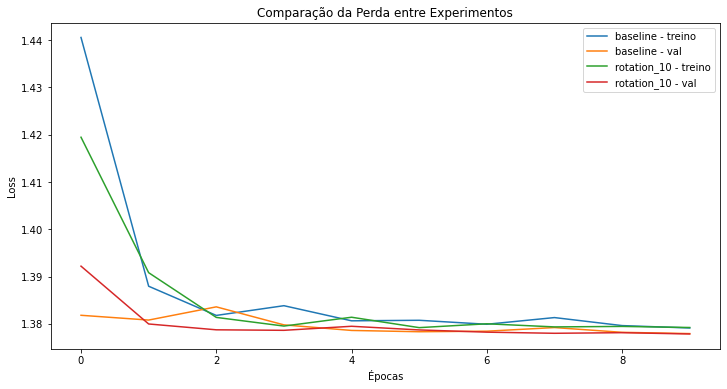

In [13]:
plot_metric(histories, 'loss', 'Comparação da Perda entre Experimentos')

# Combinação das Melhores Técnicas

Agora, vamos treinar o modelo combinando as técnicas que apresentaram os melhores resultados.

In [ ]:
def combined_augmentation(image):
    image = random_rotation(image, max_angle=15)
    image = flip_horizontal(image)
    image = random_shear(image, shear_level=10 * np.pi / 180)
    return image

def create_combined_dataset():
    ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
    ds = ds.map(
        lambda x, y: (load_and_preprocess_image(x), y)
    ).map(
        lambda x, y: (combined_augmentation(x), y)
    ).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# Criar o dataset combinado
train_ds_combined = create_combined_dataset()

Treinar o Modelo com o Dataset Combinado

In [ ]:
# Recriar e compilar o modelo
model = create_model(num_classes)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Treinar o modelo
history_combined = model.fit(
    train_ds_combined,
    validation_data=test_ds,
    epochs=epochs
)

# Salvar o histórico
histories['combined'] = history_combined

Avaliar os Resultados com a Combinação

In [ ]:
# Plotar as curvas de acurácia
plot_metric({'baseline': histories['baseline'], 'combined': histories['combined']}, 'accuracy', 'Comparação de Acurácia - Baseline vs Combinado')

# Plotar as curvas de perda
plot_metric({'baseline': histories['baseline'], 'combined': histories['combined']}, 'loss', 'Comparação de Perda - Baseline vs Combinado')